In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import argparse
import os
import shutil
import time
import random
import copy


import torch
from sklearn.metrics import precision_score,recall_score
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose

import torchmetrics

#from torchinfo import summary

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn
import torch.nn.parallel
import torch.nn.init as init
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, random_split
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

In [3]:
import argparse
import os
import shutil
import time
import random
import numpy as np

import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

In [4]:
import torch
import torch.nn as nn

torch.autograd.set_detect_anomaly(True)

In [64]:
class CustomBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(CustomBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.layers(x)
        out += self.shortcut(identity)
        out = nn.ReLU(inplace=True)(out)
        return out

In [68]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.layers = nn.Sequential(
            resnet18.conv1,
            resnet18.bn1,
            resnet18.relu,
            resnet18.maxpool,
            resnet18.layer1[0],
            resnet18.layer1[1],
            #CustomBlock(64, 64),  # Added custom block to layer1
            resnet18.layer2[0],
            resnet18.layer2[1],
            resnet18.layer3[0],
            resnet18.layer3[1],
            resnet18.layer4[0],
            
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
# Instantiate the model
model =  FeatureExtractor()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 6448192


In [67]:
# Instantiate the model
model = FeatureExtractor()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.weight - 1728
layers.1.weight - 64
layers.1.bias - 64
layers.4.conv1.weight - 36864
layers.4.bn1.weight - 64
layers.4.bn1.bias - 64
layers.4.conv2.weight - 36864
layers.4.bn2.weight - 64
layers.4.bn2.bias - 64
layers.5.conv1.weight - 36864
layers.5.bn1.weight - 64
layers.5.bn1.bias - 64
layers.5.conv2.weight - 36864
layers.5.bn2.weight - 64
layers.5.bn2.bias - 64
layers.6.layers.0.weight - 36864
layers.6.layers.1.weight - 64
layers.6.layers.1.bias - 64
layers.6.layers.3.weight - 36864
layers.6.layers.4.weight - 64
layers.6.layers.4.bias - 64
layers.6.layers.6.weight - 36864
layers.6.layers.7.weight - 64
layers.6.layers.7.bias - 64
layers.7.conv1.weight - 73728
layers.7.bn1.weight - 128
layers.7.bn1.bias - 128
layers.7.conv2.weight - 147456
layers.7.bn2.weight - 128
layers.7.bn2.bias - 128
layers.7.downsample.0.weight - 8192
layers.7.downsample.1.weight - 128
layers.7.downsample.1.bias - 128
layers.8.conv1.weight - 147456
layers.8.bn1.weight - 128
layers.8.bn1.bias - 128
layers

In [7]:
class Predictor(nn.Module):
    def __init__(self, num_classes=10):
        super(Predictor, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.layers = nn.Sequential(
            resnet18.layer4[1],
            resnet18.avgpool,
            nn.Flatten(),
            nn.Linear(resnet18.fc.in_features, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [69]:
# Instantiate the model
model =  Predictor()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 4725770


In [70]:
# Instantiate the model
model = Predictor()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.conv1.weight - 2359296
layers.0.bn1.weight - 512
layers.0.bn1.bias - 512
layers.0.conv2.weight - 2359296
layers.0.bn2.weight - 512
layers.0.bn2.bias - 512
layers.3.weight - 5120
layers.3.bias - 10


In [8]:
class Attacker(nn.Module):
    def __init__(self, num_classes=1):
        super(Attacker, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.layers = nn.Sequential(
            resnet18.layer4[1],
            resnet18.avgpool,
            nn.Flatten(),
            nn.Linear(resnet18.fc.in_features, num_classes),
        )

    def forward(self, x):
        x = self.layers(x)
        x = torch.sigmoid(x)
        return x

In [72]:
# Instantiate the model
model =  Attacker()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 4721153


In [47]:
# Instantiate the model
model = Attacker()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.conv1.weight - 2359296
layers.0.bn1.weight - 512
layers.0.bn1.bias - 512
layers.0.conv2.weight - 2359296
layers.0.bn2.weight - 512
layers.0.bn2.bias - 512
layers.3.weight - 512
layers.3.bias - 1


In [9]:
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].shape[0] == tensor.shape[0] for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        X = self.tensors[0][index]
        if self.transform is not None:
            X = self.transform(X)
        return X, tuple(self.tensors[i][index] for i in range(1, len(self.tensors)))
    
    def __len__(self):
        return self.tensors[0].shape[0]

In [10]:
tfms = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 100


#50k clf_trainds
clf_trainds = CIFAR10(root='PyTorch-StudioGAN/data/', transform=tfms)
print(len(clf_trainds))
#clf_train_idx = 25k
#clf_test_idx = 25k
clf_train_idx, clf_test_idx = train_test_split(
    np.arange(len(clf_trainds.targets)), test_size=0.5, shuffle=True, stratify=clf_trainds.targets
)
train_sampler = sampler.SubsetRandomSampler(clf_train_idx)
test_sampler = sampler.SubsetRandomSampler(clf_test_idx)

#creating clf_train and clf_test dataloader
clf_train_dl = DataLoader(clf_trainds, batch_size=batch_size, sampler=train_sampler)
clf_test_dl = DataLoader(clf_trainds, batch_size=batch_size, sampler=test_sampler)

#creating attacker dataset
y_true_atk = [t for t in clf_trainds.targets]
#25k 0 and 25k 1
y_atk = np.zeros(len(clf_trainds), dtype=int)
y_atk[clf_train_idx.tolist()] = 1

atk_trainds = CustomTensorDataset(
    tensors=(clf_trainds.data,torch.tensor(y_true_atk), torch.tensor(y_atk)),
    transform=tfms
)
atk_train_idx, atk_test_idx = train_test_split(
    np.arange(len(atk_trainds.tensors[2].tolist())), test_size=0.2, shuffle=True, stratify=atk_trainds.tensors[2].tolist()
)
atk_train_sampler = sampler.SubsetRandomSampler(atk_train_idx)
atk_test_sampler = sampler.SubsetRandomSampler(atk_test_idx)

atk_train_dl = DataLoader(atk_trainds, batch_size=batch_size, sampler=atk_train_sampler)
atk_test_dl = DataLoader(atk_trainds, batch_size=batch_size, sampler=atk_test_sampler)



50000


In [11]:

def adjust_learning_rate(epoch, init_lr=0.001):
    schedule = [12]
    cur_lr = init_lr
    for schedule_epoch in schedule:
        if epoch >= schedule_epoch:
            cur_lr *= 0.1
    return cur_lr

In [76]:
#pretraining FE+CF
criterion = nn.CrossEntropyLoss()
train_loss = []
test_loss = []
test_acc = []

def train_FE_CF2(FE, CF, data_train_loader, current_lr, vis=None):
    FE.train()
    CF.train()
    FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_CF = 0
    for i, (images, labels) in enumerate(data_train_loader):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        features = FE(images)
        # feed only private images to the classifier
        output_CF = CF(features)
        loss_CF = criterion(output_CF, labels)
        

        FE_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        loss_CF.backward()
        CF_optimizer.step()
        FE_optimizer.step()
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss Classifier: {:.6f}\t'.format(
                i, i * len(images), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_CF.item()))

    return FE, CF

In [ ]:
import numpy as np
from opacus import PrivacyEngine
from opacus.utils.module_modification import convert_batchnorm_modules
from opacus.utils.batch_memory_manager import BatchMemoryManager
import torch
import torch.nn as nn
import torch.optim as optim

def accuracy(preds, labels):
    return (preds == labels).mean()

def train_FE_CF2_DP(FE, CF, data_train_loader, current_lr, epsilon, delta, max_grad_norm, total_epoch, criterion, device):
    FE.train()
    CF.train()
    FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    
    # Initialize the PrivacyEngine
    privacy_engine = PrivacyEngine(
        secure_rng=True,
        max_grad_norm=max_grad_norm,
    )
    FE, FE_optimizer, data_train_loader = privacy_engine.make_private_with_epsilon(
        module=FE,
        optimizer=FE_optimizer,
        data_loader=data_train_loader,
        epochs=total_epoch,
        target_epsilon=epsilon,
        target_delta=delta
    )

    losses = []
    top1_acc = []

    with BatchMemoryManager(data_loader=data_train_loader, max_physical_batch_size=128, optimizer=FE_optimizer) as memory_safe_data_loader:
        for epoch in range(total_epoch):
            for i, (images, labels) in enumerate(memory_safe_data_loader):
                images, labels = images.to(device), labels.to(device)

                FE_optimizer.zero_grad()

                # Forward pass through FE and then CF
                features = FE(images)
                output = CF(features)
                loss = criterion(output, labels)

                # Calculate accuracy
                preds = np.argmax(output.detach().cpu().numpy(), axis=1)
                labels_np = labels.detach().cpu().numpy()
                acc = accuracy(preds, labels_np)

                losses.append(loss.item())
                top1_acc.append(acc)

                loss.backward()
                FE_optimizer.step()

                if (i + 1) % 200 == 0:
                    epsilon_current = privacy_engine.get_epsilon(delta)
                    print(f"\tTrain Epoch: {epoch} [{i+1}/{len(data_train_loader)}]\t"
                          f"Loss: {np.mean(losses):.6f} "
                          f"Acc@1: {np.mean(top1_acc) * 100:.6f}% "
                          f"(ε = {epsilon_current:.2f}, δ = {delta})")
    
    return FE, CF


In [93]:
import opacus
print(opacus.__version__)


0.15.0


In [91]:
pip install --upgrade opacus

In [77]:
def test_FE_CF2(FE, CF, data_test_loader):
    FE.eval()
    CF.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0
    #size= len(data_test_loader)//2

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_test_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            features = FE(images)
            #classfier_features= features[privlabe==1]
            output = CF(features)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            avg_acc += pred.eq(labels.view_as(pred)).sum()
            counter += 1

    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    test_loss.append(avg_loss)
    test_acc.append(avg_acc)

In [64]:
test_atk_loss=[]  # list to store loss values
def eval_clf(fe, clf, clf_test_dl, clf_criterion, device):
    fe.eval()
    clf.eval()
    acc = torchmetrics.Accuracy().to(device)
    loss = []
    with torch.no_grad():
        for (X, y) in clf_test_dl:
            X, y = X.to(device), y.to(device)
            features = fe(X)
            clf_y = clf(features)
            loss.append(clf_criterion(clf_y, y).item())
            test_atk_loss.append(loss)  # add loss to list
            acc(clf_y, y)
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [65]:
# create a directory to save models
save_dir = os.path.join(os.getcwd(), 'resnet-DP-SGD')
os.makedirs(save_dir, exist_ok=True)

# define the file name for each model
fe_model_file = os.path.join(save_dir, 'FE.pth')
cf_model_file = os.path.join(save_dir, 'CF.pth')
inf_model_file=os.path.join(save_dir,'INF.pth')

In [80]:
total_epoch=300
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clf_criterion = nn.CrossEntropyLoss().to(device)
def get_FE_CF():
    FE = FeatureExtractor()
    CF = Predictor()
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            FE = torch.nn.DataParallel(FE)
            CF = torch.nn.DataParallel(CF)
        FE = FE.cuda()
        CF = CF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            FE, CF = train_FE_CF2(FE, CF, clf_train_dl, current_lr, vis=None)
            #test_FE_CF2(FE, CF, clf_test_dl)
            eval_clf(FE,CF,clf_test_dl,clf_criterion,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "Models/mix/pre_train/FE.pth")
        torch.save(CF.module, "Models/mix/pre_train/CF.pth")
    else:
        torch.save(FE, fe_model_file)
        torch.save(CF, cf_model_file)

    return FE, CF

In [72]:
import torch.nn as nn
import torchvision.models as models

def replace_batchnorm_with_groupnorm(module):
    for child_name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            setattr(module, child_name, nn.GroupNorm(num_groups=1, num_channels=child.num_features))
        else:
            replace_batchnorm_with_groupnorm(child)

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        # Modify the first conv layer if needed
        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Replace BatchNorm with GroupNorm in resnet18
        replace_batchnorm_with_groupnorm(resnet18)

        self.layers = nn.Sequential(
            resnet18.conv1,
            resnet18.bn1,
            resnet18.relu,
            resnet18.maxpool,
            resnet18.layer1,
            resnet18.layer2,
            resnet18.layer3,
            resnet18.layer4,
        )

    def forward(self, x):
        return self.layers(x)


In [88]:
import torch
import torch.nn as nn
import numpy as np
import torchmetrics

# Assuming clf_train_dl and clf_test_dl are defined elsewhere
# as your training and testing dataloaders respectively

total_epoch = 300
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clf_criterion = nn.CrossEntropyLoss().to(device)

# Example values for DP-SGD parameters
epsilon = 1.0  # Example value; adjust based on your privacy budget
delta = 1e-5  # Example value; should be smaller than 1/size of your dataset
max_grad_norm = 1.0  # Example value; adjust for clipping gradients
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clf_criterion = nn.CrossEntropyLoss().to(device)
def get_FE_CF_DP():
    FE = FeatureExtractor()  # Define your FeatureExtractor model
    CF = Predictor()  # Define your Predictor model
    
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            FE = torch.nn.DataParallel(FE)
            CF = torch.nn.DataParallel(CF)
        FE = FE.cuda()
        CF = CF.cuda()
    
    try:
        for epoch in range(total_epoch):
            print("Epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)  # Assuming adjust_learning_rate is defined elsewhere
            # Update to pass privacy parameters to the training function
            FE, CF = train_FE_CF2_DP(FE, CF, clf_train_dl, current_lr, epsilon, delta, max_grad_norm, total_epoch, clf_criterion,vis=None)

            # Assuming eval_clf is defined elsewhere and handles evaluation/logging
            eval_clf(FE, CF, clf_test_dl, clf_criterion, device)
    except KeyboardInterrupt:
        pass
    
    # Adjusted to handle model saving based on potential DataParallel wrapping
    if torch.cuda.device_count() > 1:
        torch.save(FE.module.state_dict(), "Models/mix/pre_train/FE.pth")
        torch.save(CF.module.state_dict(), "Models/mix/pre_train/CF.pth")
    else:
        torch.save(FE.state_dict(), "Models/mix/pre_train/FE.pth")
        torch.save(CF.state_dict(), "Models/mix/pre_train/CF.pth")

    return FE, CF


In [ ]:
FE, CF = get_FE_CF_DP()

In [81]:
#overfitting on data
FE, CF = get_FE_CF()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 2.814837	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 1.375778	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.989575	
Classifier Loss: 1.1336134631633759 | Classifier Accuracy: 0.6074000000953674
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 1.046663	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 0.710478	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.888275	
Classifier Loss: 1.024956937789917 | Classifier Accuracy: 0.65447998046875
epoch 2
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.498657	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 0.579172	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.805810	
Classifier Loss: 0.8832351121902465 | Classifier Accuracy: 0.703719973564148
epoch 3
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.485019	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 0.534567	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.719772	
Classifier Loss: 0.9378385593891144 | Classifier Accuracy: 0.699919998

In [82]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad_(False) 
    model.eval()

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad_(True)
    model.train()

In [83]:
def get_precision_recall(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, predicted, average='macro',zero_division=0)
    recall = recall_score(labels, predicted, average='macro')
    return precision, recall

In [84]:
#train pretrained FE+attacker
device = 'cuda' if torch.cuda.is_available() else 'cpu'
atk_criterion = nn.BCEWithLogitsLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
#list for saving features 
#feature_list = []
#for plotting
#train_losses = []
def train_FE_INF(FE, INF, data_train_loader, current_lr,device, vis=None):
    INF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_INF = 0
    running_precision=0
    running_recall=0
    freeze(FE)
    for i,(X, (y1, y2)) in enumerate(atk_train_dl):
        #if torch.cuda.is_available():
        X, y1,y2= X.to(device), y1.to(device),y2.to(device)
        features = FE(X)
        #for plotting T-SNE
        #feature_list.append(features.detach().cpu().numpy())
        # feed them to the inf model
        pred_private_labels = INF(features)
        #pred_private_labels= torch.round(pred_private_labels)
        #y2=y2.float()
        y2 = y2.unsqueeze(1)
        loss_INF =atk_criterion(pred_private_labels,y2.float())
        ######
        #train_losses.append(loss_INF.item())
        precision, recall = get_precision_recall(pred_private_labels,y2)
        #FE_optimizer.zero_grad()
        INF_optimizer.zero_grad()
        loss_INF.backward()
        INF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss attacker: {:.6f}\t Precision attacker: {:.6f}\t recall attacler: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_INF.detach().item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return FE, INF

In [85]:
INF_test_loss=[]
INF_test_acc=[]
loss_fn = nn.BCEWithLogitsLoss().to(device)
def test_FE_INF(FE, INF_model, data_test_loader,device):
    FE.eval()
    INF_model.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0

    with torch.no_grad():
        for i, (X,(y1,y2)) in enumerate(data_test_loader):
            #if torch.cuda.is_available():
            X,y1,y2=X.to(device),y1.to(device),y2.to(device)
#           private_labels,n=private_labels_gaining(labels)
            features = FE(X)
            output = INF_model(features)
            #output=torch.round(output)
            #y2=y2.float()
            y2= y2.unsqueeze(1)
            avg_loss += loss_fn(output, y2.float()).sum()
            pred = output.detach() > 0.5
            avg_acc += pred.eq(y2.view_as(pred)).sum()
            counter += 1
            
    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    #print(privlabels)
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    INF_test_loss.append(avg_loss)
    INF_test_acc.append(avg_acc)

In [86]:
total_epoch=100
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_FE_INF():
    FE = torch.load(fe_model_file)
    INF = Attacker()
    if torch.cuda.is_available():
        FE = FE.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            FE, INF = train_FE_INF(FE, INF, atk_train_dl, current_lr, device,vis=None)
            test_FE_INF(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "Models/mix/pre_train/FE.pth")
        torch.save(INF.module, "Models/mix/pre_train/CF.pth")
    else:
        #torch.save(FE, fe_model_file)
        torch.save(INF, inf_model_file)
    return FE, INF

In [87]:
FE, INF = get_FE_INF()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.794103	 Precision attacker: 0.002750	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.694185	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.690535	 Precision attacker: 0.003100	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.686288	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Test Avg. Loss: 0.680479, Accuracy: 54.520000
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.682801	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.688476	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.648947	 Precision attacker: 0.001950	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.654534	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.675114, Accuracy: 56.880000
ep

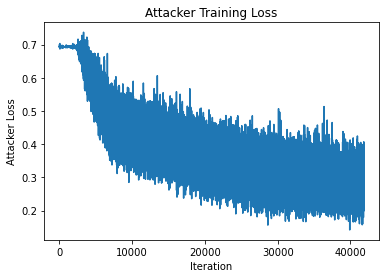

In [242]:
#plotting attacker loss during training 
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Attacker Loss')
plt.title('Attacker Training Loss')
plt.show()

In [125]:
criterion = nn.CrossEntropyLoss().cuda()
loss_fn = nn.BCEWithLogitsLoss().cuda()

def train(FE_model,INF_model, CF_model, trainloader, current_lr,current_lr_atk,tradoff=0.5 ):
    FE_model.train()
    INF_model.train()
    CF_model.train()
    #tradoff=0
    
    FE_optimizer = optim.Adam(FE_model.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF_model.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF_model.parameters(), lr=current_lr_atk, weight_decay=1e-4)
    
    for i, (images, (labels, privlabels)) in enumerate(trainloader):
        if torch.cuda.is_available():
            images, labels, privlabels = images.cuda(), labels.cuda(), privlabels.cuda()

        # get features from the feature extractor
        features = FE_model(images)
        
        # feed them to the inf model
        pred_private_labels = INF_model(features)
        loss_INF = loss_fn(pred_private_labels, privlabels.reshape(-1,1).float())

        # feed only private images==1 to the classifier
        classifier_features = features[privlabels == 1]
        output_CF = CF_model(classifier_features)
        loss_CF = criterion(output_CF, labels[privlabels == 1])
        
        # compute loss and backprop
        loss = -tradoff * loss_INF + (1. - tradoff) * loss_CF
        
        FE_optimizer.zero_grad()
        loss.backward()
        FE_optimizer.step()

        
         # get features from the feature extractor
        features = FE_model(images).detach()
        INF_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        
        # feed them to the inf model
        pred_private_labels = INF_model(features)
        loss_INF = loss_fn(pred_private_labels, privlabels.reshape(-1,1).float())
        loss_INF.backward()
        INF_optimizer.step()

       
        # feed only private images to the classifier
        classifier_features = features[privlabels == 1]
        output_CF = CF_model(classifier_features)
        loss_CF = criterion(output_CF, labels[privlabels == 1])
        loss_CF.backward()
        CF_optimizer.step()

        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss Classifier: {:.6f}\tLoss Attacker: {:.6f}'.format(
                i, i * len(images), len(trainloader.dataset),
                100. * i / len(trainloader), loss_CF.item(), loss_INF.item()))

    return FE_model, INF_model, CF_model       

In [126]:
# create a directory to save models
save_dir = os.path.join(os.getcwd(), 'resnet-0.5')
os.makedirs(save_dir, exist_ok=True)

# define the file name for each model
fe_model_file_defense = os.path.join(save_dir, 'FE_defense.pth')
cf_model_file_defense = os.path.join(save_dir, 'CF_defense.pth')
inf_model_file_defense = os.path.join(save_dir, 'INF_defense.pth')

In [127]:
total_epoch=300
lr=0.0001
lr_atk=3e-3
#lr=0.1
tradoff=0.5
def get_FE_defense():
    #using FE and CF after pretraining them
    FE = torch.load(fe_model_file)
    #FE=AlexNet_FE()
    #CF=AlexNet_predictor()
    CF = torch.load(cf_model_file)
    INF=torch.load(inf_model_file)
    #INF = Attacker()
    if torch.cuda.is_available():
        FE = FE.cuda()
        CF = CF.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            current_lr_atk = adjust_learning_rate(epoch,lr_atk)
            FE, INF, CF =train(FE,INF, CF, atk_train_dl, current_lr,current_lr_atk, tradoff)
            #test_attacker_defense(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "FE_defense.pth")
        torch.save(CF.module, "CF_defense.pth")
        torch.save(INF.module, "INF_defense.pth")
    else:
        torch.save(FE,fe_model_file_defense)
        torch.save(INF,inf_model_file_defense)
        torch.save(CF, cf_model_file_defense)
    return FE

In [128]:
FE=get_FE_defense()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.001524	Loss Attacker: 0.646964
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.000353	Loss Attacker: 0.694239
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 0.000823	Loss Attacker: 0.690124
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 0.000540	Loss Attacker: 0.705411
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.000311	Loss Attacker: 0.715291
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.000213	Loss Attacker: 0.683131
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 0.000450	Loss Attacker: 0.682555
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 0.005814	Loss Attacker: 0.679569
epoch 2
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.000387	Loss Attacker: 0.702817
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.000501	Loss Attacker: 0.702071
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 0.000784	Loss Attacker: 0.681800
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 0.001206	Loss Attacker: 0.694205
epoch 3
Epoch: 0 [0/50000

In [135]:
#train attacker after applying our defense
atk_criterion = nn.BCEWithLogitsLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
def train_attacker_defense(FE, INF, data_train_loader, current_lr,device, vis=None):
    INF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_INF = 0
    running_precision=0
    running_recall=0
    #freezing the FE
    freeze(FE)
    for i,(X, (y1, y2)) in enumerate(data_train_loader):
        #if torch.cuda.is_available():
        X, y1,y2= X.to(device), y1.to(device),y2.to(device)

        features = FE(X)
        # feed them to the inf model
        pred_private_labels = INF(features)
        #y2=y2.float()
        y2 = y2.unsqueeze(1)
        loss_INF =atk_criterion(pred_private_labels,y2.float())
        precision, recall = get_precision_recall(pred_private_labels,y2)
        #FE_optimizer.zero_grad()
        INF_optimizer.zero_grad()
        loss_INF.backward()
        INF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss attacker: {:.6f}\t Precision attacker: {:.6f}\t recall attacler: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_INF.item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return  INF

In [136]:
INF_test_loss=[]
INF_test_acc=[]
loss_fn = nn.BCEWithLogitsLoss().to(device)
def test_attacker_defense(FE, INF_model, data_test_loader,device):
    FE.eval()
    INF_model.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0
    #total_samples = 0

    with torch.no_grad():
        for i, (X,(y1,y2)) in enumerate(data_test_loader):
            #if torch.cuda.is_available():
            X,y1,y2=X.to(device),y1.to(device),y2.to(device)
            features = FE(X)
            output = INF_model(features)
            #print(output)
            y2= y2.unsqueeze(1)
            #print(y2)
            avg_loss += loss_fn(output, y2.float()).sum()
            pred = output.detach() > 0.5
            avg_acc += pred.eq(y2.view_as(pred)).sum()
            counter += 1
            #total_samples +=X.shape[0]
            
    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    #print(privlabels)
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    INF_test_loss.append(avg_loss)
    INF_test_acc.append(avg_acc)

In [137]:
total_epoch=100
lr=0.000003
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_INF_defense():
    FE = torch.load(fe_model_file_defense)
    #INF= AlexNet_attacker()
    INF=torch.load(inf_model_file)
    if torch.cuda.is_available():
        FE = FE.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch,lr)
            INF = train_attacker_defense(FE, INF, atk_train_dl, current_lr, device,vis=None)
            test_attacker_defense(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass

    return FE,INF

In [138]:
FE,INF = get_INF_defense()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.757202	 Precision attacker: 0.002650	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.747085	 Precision attacker: 0.002800	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.721890	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.700098	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Test Avg. Loss: 0.714098, Accuracy: 51.850000
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.755504	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.715439	 Precision attacker: 0.002450	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.699373	 Precision attacker: 0.002250	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.677481	 Precision attacker: 0.002150	 recall attacler: 0.005000	
Test Avg. Loss: 0.711892, Accuracy: 51.190000
ep

In [129]:
#train classifier after applying our defense
clf_criterion = nn.CrossEntropyLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
def train_classifier_defense(FE, CF, data_train_loader, current_lr,device, vis=None):
    CF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_CF = 0
    running_precision=0
    running_recall=0
    #freezing the FE
    freeze(FE)
    for i,(X, y) in enumerate(clf_train_dl):
        #if torch.cuda.is_available():
        X, y= X.to(device), y.to(device)

        features = FE(X)
        # feed them to the inf model
        out_CF=CF(features)
        #pred_private_labels= torch.round(pred_private_labels)
        #y2=y2.float()
        #y = y.unsqueeze(1)
        loss_CF =clf_criterion(out_CF,y)
        precision, recall = get_precision_recall(out_CF,y)
        #FE_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        loss_CF.backward()
        CF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss classifier: {:.6f}\t Precision classifier: {:.6f}\t recall classifier: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_CF.item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return  CF

In [130]:
def eval_clf_defense(fe, clf, clf_test_dl, clf_criterion, device):
    fe.eval()
    clf.eval()
    acc = torchmetrics.Accuracy().to(device)
    loss = []
    with torch.no_grad():
        for (X, y) in clf_test_dl:
            X, y = X.to(device), y.to(device)
            features = fe(X)
            clf_y = clf(features)
            loss.append(clf_criterion(clf_y, y).item())
            acc(clf_y, y)
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [139]:
total_epoch=100
lr=3e-6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_clf_defense():
    FE = torch.load(fe_model_file_defense)
    #CF= AlexNet_predictor()
    CF=torch.load(cf_model_file)
    if torch.cuda.is_available():
        FE = FE.cuda()
        CF= CF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            CF= train_classifier_defense(FE, CF, clf_train_dl, current_lr, device,vis=None)
            eval_clf_defense(FE, CF, clf_test_dl, clf_criterion, device)
    except KeyboardInterrupt:
        pass

    return CF

In [140]:
cf= get_clf_defense()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.219439	 Precision classifier: 0.009609	 recall classifier: 0.009714	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.039296	 Precision classifier: 0.009690	 recall classifier: 0.009800	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 0.033107	 Precision classifier: 0.009833	 recall classifier: 0.009917	
Classifier Loss: 1.3411289219856262 | Classifier Accuracy: 0.8073199987411499
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.032958	 Precision classifier: 0.009941	 recall classifier: 0.009909	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.071923	 Precision classifier: 0.009784	 recall classifier: 0.009840	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 0.002660	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Classifier Loss: 1.346770451784134 | Classifier Accuracy: 0.8081200122833252
epoch 2
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.050213	 Precision classifier: 0.009733	 recall classifier: 0.009882	
Epoch: 10

c:\Users\leily\anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.003024	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 0.028221	 Precision classifier: 0.009875	 recall classifier: 0.009833	
Classifier Loss: 1.3156772270202637 | Classifier Accuracy: 0.8083999752998352
epoch 5
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.035392	 Precision classifier: 0.009900	 recall classifier: 0.009917	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.022343	 Precision classifier: 0.009833	 recall classifier: 0.009889	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 0.001269	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Classifier Loss: 1.301691398859024 | Classifier Accuracy: 0.8084400296211243
epoch 6
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.111276	 Precision classifier: 0.009845	 recall classifier: 0.009809	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.031355	 Precision classifier: 0.009933	 recall classifier: 0.009909	
Epoch: 200